Setting Backend To: AvailableBackends.numpy
Chunking done: 52 chunks
Chunking done: 7 chunks


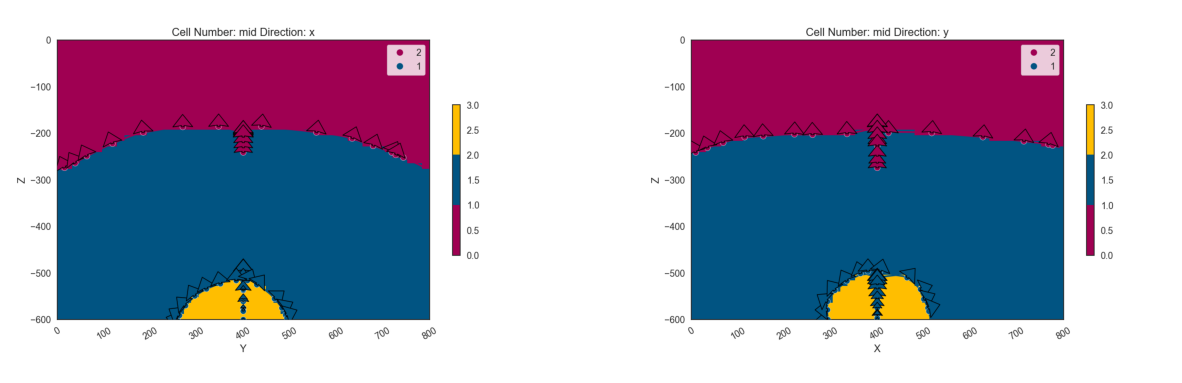

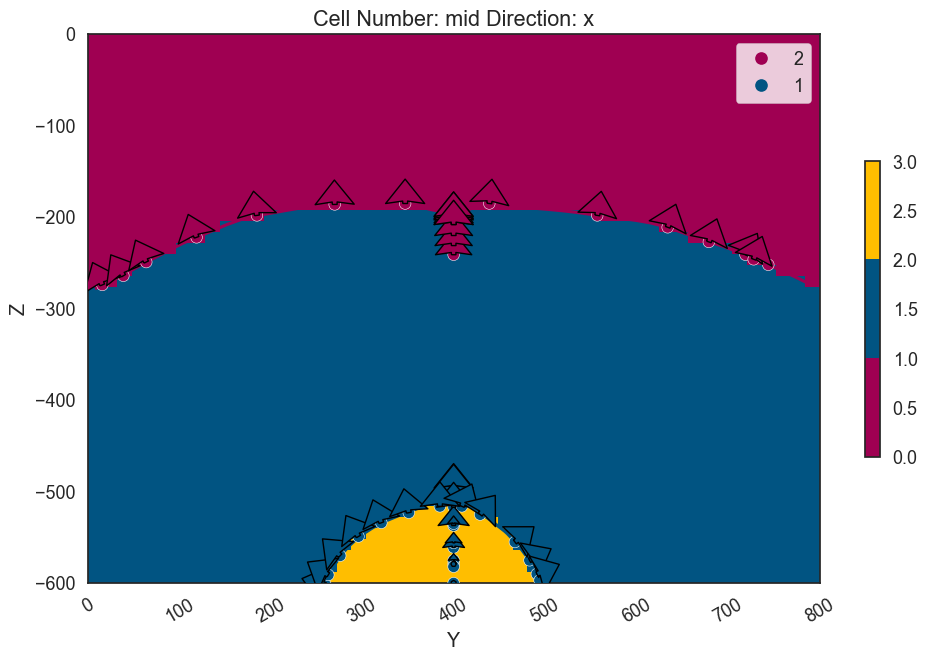

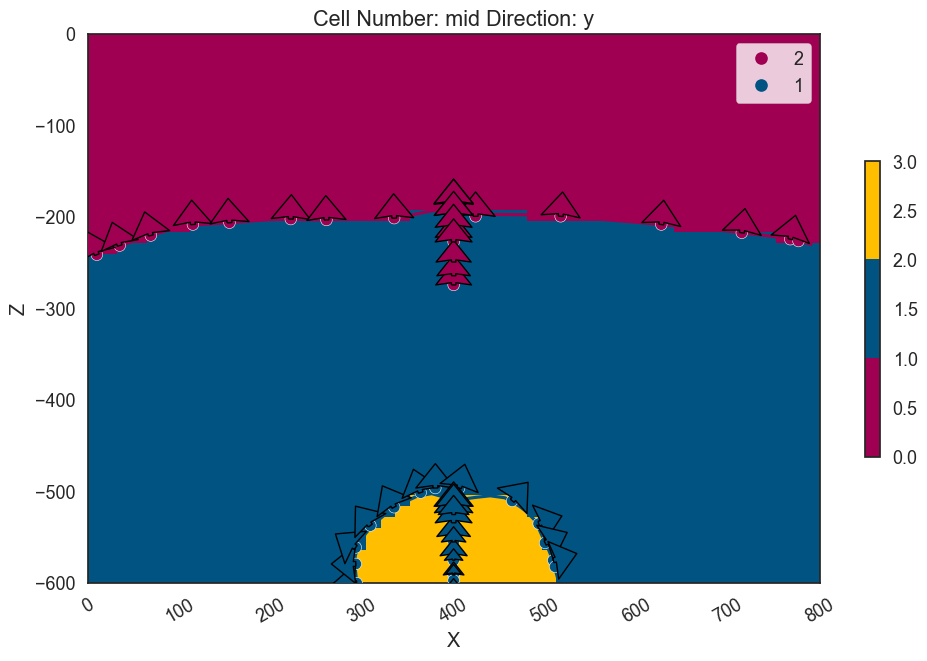

In [5]:
!pip install pygame

import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk,font
import json
import gempy as gp
import gempy_viewer as gpv
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
import warnings
import os


warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


class GeologicalModelApp:
    def __init__(self, root):
        self.root = root
        self.root.geometry("1920x1080")


        self.menu_font = font.Font(family='Arial', size=16)
        

        self.root.option_add('*Menu.font', self.menu_font)


        self.menubar = tk.Menu(root,)
        root.config(menu=self.menubar)
        
        

        self.function_menu = tk.Menu(self.menubar, tearoff=0)
        self.menubar.add_cascade(label="Model generator", menu=self.function_menu)

        

        self.function_menu.add_command(label="save/load model", command=lambda: self.show_tab(self.tab1, 'Save/Load Data'))
        self.function_menu.add_command(label="Create GemPy Model", command=lambda: self.show_tab(self.tab2, 'Create GemPy Model'))
        self.function_menu.add_command(label="Drawing", command=lambda: self.show_tab(self.tab3, 'Drawing'))
        self.function_menu.add_command(label="2D and 3D Plot", command=lambda: self.show_tab(self.tab4, '2D and 3D Plot'))
        
        self.notebook = ttk.Notebook(root)
        self.notebook.pack(fill='both', expand=True)

        self.style = ttk.Style()
        self.style.configure('TNotebook.Tab', font=('Arial', '16'))
        self.style.configure('TButton', font=('Arial', 14), padding=10, borderwidth=10, relief="flat", background="#C0E6A7")
 
        
        self.tab1 = ttk.Frame(self.notebook)
        self.tab2 = ttk.Frame(self.notebook)
        self.tab3 = ttk.Frame(self.notebook)
        self.tab4 = ttk.Frame(self.notebook)
        

        self.auto_corr = tk.IntVar()
        self.auto_corr.set(0)
        self.show_drift_var = tk.IntVar()
        self.show_drift_var.set(0)
        self.name = {}
        self.name_saved = []
        self.x_pos = {}
        self.x_pos_saved = []
        self.y_pos = {}
        self.y_pos_saved = []
        self.x_points = []
        self.y_points = []
        self.vertices_df = None
        self.normals_df = None

        # Define font styles
        self.title_font = ("Helvetica", 16, "bold")
        self.label_font = ("Helvetica", 14)
        self.entry_font = ("Helvetica", 14)
        self.button_font = ("Helvetica", 14, "bold")

        # Tab 1: Save/Load Data
        self.save_button = ttk.Button(self.tab1, text="Save Data",  command=self.save_data, style='TButton')
        self.save_button.grid(row=0, column=0, padx=10, pady=10, sticky='w')

        self.load_button = ttk.Button(self.tab1, text="Load Data",  command=self.load_data, style='TButton')
        self.load_button.grid(row=0, column=1, padx=10, pady=10, sticky='w')
        
        self.save_model_button = ttk.Button(self.tab1, text="Save Gempy Model",  command=self.save_gempy_model, style='TButton')
        self.save_model_button.grid(row=0, column=2, padx=10, pady=10, sticky='w')

        # Tab 2: Model Parameters
        self.Layer_number_label = tk.Label(self.tab2, text="Please enter the layer number:", font=self.label_font)
        self.layer_number_entry = tk.Entry(self.tab2, font=self.entry_font)
        self.layer_number_confirm = ttk.Button(self.tab2, text="Confirm", style='TButton', command=self.set_layer_name)

        self.Layer_number_label.grid(row=0, column=0, padx=10, pady=10, sticky='w')
        self.layer_number_entry.grid(row=0, column=1, padx=10, pady=10, sticky='w')
        self.layer_number_confirm.grid(row=0, column=2, padx=10, pady=10, sticky='w')

        self.en = tk.Checkbutton(self.tab2, text="Enable auto correction", variable=self.auto_corr, onvalue=1, offvalue=0, font=self.label_font)
        self.en.grid(row=1, column=0, padx=10, pady=10, sticky='w')

        # Tab 3: Drawing
        self.draw_frame = tk.Frame(self.tab3)
        self.draw_frame.grid(row=0, column=0, padx=10, pady=10, sticky='w')

        # Tab 4: 2D Plot
        self.plot_2d_frame = tk.Frame(self.tab4)
        self.plot_2d_frame.grid(row=0, column=0, padx=10, pady=10, sticky='w')

        self.plot_3d_button = ttk.Button(self.plot_2d_frame, text="Show 3D Plot", style='TButton', command=self.plot_3d)
        self.plot_3d_button.pack(pady=10)

        self.show_tab(self.tab1, 'Save/Load Data')
        self.show_tab(self.tab3, 'Drawing')
        self.show_tab(self.tab4, '2D and 3D Plot')
        self.show_tab(self.tab2, 'Create GemPy Model')

        


    def show_tab(self, tab, tab_text):

        current_tabs = {self.notebook.tab(nt, "text"): nt for nt in self.notebook.tabs()}
        

        if tab_text in current_tabs:
            self.notebook.select(current_tabs[tab_text])
        else:

            self.notebook.add(tab, text=tab_text)
            self.notebook.select(tab)




    def init_pyvista_plotter(self):
        pass  

    def combine_funcs(self, *funcs):
        def inner_combined_func(*args, **kwargs):
            for f in funcs:
                f(*args, **kwargs)
        return inner_combined_func

    def set_layer_name(self):
        for i in range(int(self.layer_number_entry.get())):
            tk.Label(self.tab2, text="Layer " + str(i + 1) + " name:", font=self.label_font).grid(row=i + 2, column=0, padx=10, pady=5, sticky='w')
            layer_name = f'Layer {str(i + 1)} name'
            self.name[layer_name] = tk.Entry(self.tab2, font=self.entry_font)
            self.name[layer_name].grid(row=i + 2, column=1, padx=10, pady=5, sticky='w')

            tk.Label(self.tab2, text="Layer " + str(i + 1) + " X section Position:", font=self.label_font).grid(row=i + 2, column=2, padx=10, pady=5, sticky='w')
            self.x_pos[layer_name] = tk.Entry(self.tab2, font=self.entry_font)
            self.x_pos[layer_name].grid(row=i + 2, column=3, padx=10, pady=5, sticky='w')

            tk.Label(self.tab2, text="Layer " + str(i + 1) + " Y section Position:", font=self.label_font).grid(row=i + 2, column=4, padx=10, pady=5, sticky='w')
            self.y_pos[layer_name] = tk.Entry(self.tab2, font=self.entry_font)
            self.y_pos[layer_name].grid(row=i + 2, column=5, padx=10, pady=5, sticky='w')

        tk.Button(self.tab2, text="Draw!", font=self.button_font, command=self.combine_funcs(self.save_name, self.set_draw, lambda: self.show_tab(self.tab3, 'Drawing'))).grid(row=i + 3, column=0, padx=10, pady=10, sticky='w')

    def save_name(self):
        for i in range(int(self.layer_number_entry.get())):
            self.name_saved.append(self.name[f'Layer {str(i + 1)} name'].get())

        for i in range(int(self.layer_number_entry.get())):
            self.x_pos_saved.append(self.x_pos[f'Layer {str(i + 1)} name'].get())

        for i in range(int(self.layer_number_entry.get())):
            self.y_pos_saved.append(self.y_pos[f'Layer {str(i + 1)} name'].get())

    def draw_X(self):
        %run draw.py

        with open("curve_points.json", "r") as file:
            points = json.load(file)

        slice_x = np.array(points)[-1]
        self.x_points.append(slice_x)

        fig = plt.Figure(figsize=(5, 4), dpi=100)
        ax = fig.add_subplot()

        for i in range(len(self.x_points)):
            ax.plot(self.x_points[i][:, 0], self.x_points[i][:, 1], "-")
        ax.set_xlim(0, 800)
        ax.set_ylim(0, 600)
        ax.grid()
        ax.invert_yaxis()

        # 显示绘图结果
        canvas = FigureCanvasTkAgg(fig, master=self.draw_frame)
        canvas.draw()
        canvas.get_tk_widget().grid(row=int(self.layer_number_entry.get()) + 10, column=0, rowspan=1, columnspan=5, padx=10, pady=10)

    def draw_Y(self):
        %run draw.py

        with open("curve_points.json", "r") as file:
            points = json.load(file)
        slice_y = np.array(points)[-1]
        self.y_points.append(slice_y)

        fig = plt.Figure(figsize=(5, 4), dpi=100)
        ax = fig.add_subplot()

        for i in range(len(self.y_points)):
            ax.plot(self.y_points[i][:, 0], self.y_points[i][:, 1], "-")
        ax.set_xlim(0, 800)
        ax.set_ylim(0, 600)
        ax.grid()
        ax.invert_yaxis()

        canvas = FigureCanvasTkAgg(fig, master=self.draw_frame)
        canvas.draw()
        canvas.get_tk_widget().grid(row=int(self.layer_number_entry.get()) + 10, column=5, rowspan=1, columnspan=5, padx=10, pady=10)

    def set_draw(self):
        for i in range(int(self.layer_number_entry.get())):
            ttk.Button(self.draw_frame, text="Please draw Layer " + str(i + 1) + " X cross-section", style='TButton', command=self.draw_X).grid(row=i, column=0, padx=10, pady=5, sticky='w')
            ttk.Button(self.draw_frame, text="Please draw Layer " + str(i + 1) + " Y cross-section", style='TButton', command=self.draw_Y).grid(row=i, column=1, padx=10, pady=5, sticky='w')

        ttk.Button(self.tab3, text="Create model!", style='TButton', command=self.create_model).place(relx=0.6, rely=0.015, )

    def surface_all(self, auto_corr):
        surface_all = pd.DataFrame(columns=('X', 'Y', 'Z', 'formation'))
        for i in range(np.array(self.x_points).shape[0]):
            slice_x = np.array(self.x_points)[i]
            slice_y = np.array(self.y_points)[i]
            slice_x_max = np.array([slice_x[:, 0][slice_x[:, 1] == slice_x[:, 1].min()][0], slice_x[:, 1].min()])
            slice_y_max = np.array([slice_y[:, 0][slice_y[:, 1] == slice_y[:, 1].min()][0], slice_y[:, 1].min()])

            if auto_corr:
                diff = slice_x_max - slice_y_max
                slice_y[:, 1] += diff[1]

            x_slice = [slice_x[:, 0],
                       np.ones(len(slice_x)) * int(self.x_pos_saved[i]),
                       -slice_x[:, 1]]
            x_slice = pd.DataFrame((np.array(x_slice).T), columns=('X', 'Y', 'Z'))

            y_slice = [np.ones(len(slice_y)) * int(self.y_pos_saved[i]),
                       slice_y[:, 0],
                       -slice_y[:, 1]]
            y_slice = pd.DataFrame((np.array(y_slice).T), columns=('X', 'Y', 'Z'))

            formation = pd.DataFrame(data={'formation': [self.name_saved[i]] * (len(x_slice) + len(y_slice))})

            surface = pd.concat([pd.concat([x_slice, y_slice], ignore_index=True), formation], axis=1)

            surface_all = pd.concat([surface_all, surface], ignore_index=True)
        return surface_all

    def cal_orientation(self, x, y):
        x1 = y[1] - x[1]
        y1 = y[0] - x[0]
        return x1 / np.sqrt(x1 ** 2 + y1 ** 2), y1 / np.sqrt(x1 ** 2 + y1 ** 2)

    def save_data(self):
        data = {
            "name_saved": self.name_saved,
            "x_pos_saved": self.x_pos_saved,
            "y_pos_saved": self.y_pos_saved,
            "x_points": [points.tolist() for points in self.x_points],
            "y_points": [points.tolist() for points in self.y_points]
        }
        file_path = filedialog.asksaveasfilename(defaultextension=".json", filetypes=[("JSON files", "*.json")])
        if file_path:
            with open(file_path, "w") as file:
                json.dump(data, file)

    def load_data(self):
        file_path = filedialog.askopenfilename(filetypes=[("JSON files", "*.json")])
        if file_path:
            with open(file_path, "r") as file:
                data = json.load(file)
            self.name_saved = data["name_saved"]
            self.x_pos_saved = data["x_pos_saved"]
            self.y_pos_saved = data["y_pos_saved"]
            self.x_points = [np.array(points) for points in data["x_points"]]
            self.y_points = [np.array(points) for points in data["y_points"]]
            messagebox.showinfo("Load Data", "Data loaded successfully!")
            self.create_model()  # Automatically create model after loading data

    def save_gempy_model(self):
        directory = filedialog.askdirectory()
        if directory:
            geo_model = self._create_model_logic(self.auto_corr.get())
            # gp.set_interpolator(geo_model, compile_theano=True, theano_optimizer='fast_compile')
            sol = gp.compute_model(gempy_model=geo_model,engine_config=gp.data.GemPyEngineConfig(use_gpu=False,
                                                            dtype='float32', backend=gp.data.AvailableBackends.PYTORCH))

            # gpv = gp.plot_3d(geo_model, image=False, plotter_type='basic', show_data=0)
            
            surface_points_path = os.path.join(directory, 'surface_points.csv')
            orientations_path = os.path.join(directory, 'orientations.csv')
            
            geo_model.surface_points_copy.df.to_csv(surface_points_path)
            geo_model.orientations_copy.df.to_csv(orientations_path)
            
            for name in self.name_saved:
                mesh_path = os.path.join(directory, f'{name}.vtp')
                try:
                    gpv.plot_3d(geo_model, image=False, plotter_type='basic', show_data=0).surface_poly[name].save(mesh_path)
                except KeyError as e:
                    print(f"Error: {e}")
                    messagebox.showerror("Save Error", f"Could not save {name}.vtp. Please check the surface name.")
                    continue
            
            messagebox.showinfo("Save Gempy Model", "Gempy model saved successfully!")

    

    def create_model(self):
        geo_model = self._create_model_logic(self.auto_corr.get())

        # gp.set_interpolator(geo_model, compile_theano=True, theano_optimizer='fast_compile')
        sol = gp.compute_model(geo_model)
        self._plot_2d(geo_model)

    def plot_3d(self):
        geo_model = self._create_model_logic(self.auto_corr.get())
        # gp.set_interpolator(geo_model, compile_theano=True, theano_optimizer='fast_compile')
        sol = gp.compute_model(geo_model)
        self._plot_3d(geo_model)

    def _create_model_logic(self, auto_corr):

        # Initialize a list to store orientation data for each slice
        orientation_data = []


        # Iterate over slices
        self.x_points = np.array(self.x_points, dtype=object)
        self.y_points = np.array(self.y_points, dtype=object)

        for n in range(np.array(self.x_points).shape[0]):
            slice_x = np.array(self.x_points)[n]
            slice_y = np.array(self.y_points)[n]

            # Calculate the max points in x and y slices
            slice_x_max = np.array([slice_x[:, 0][slice_x[:, 1] == slice_x[:, 1].min()][0], slice_x[:, 1].min()])
            slice_y_max = np.array([slice_y[:, 0][slice_y[:, 1] == slice_y[:, 1].min()][0], slice_y[:, 1].min()])

            # Apply correction if auto_corr is True
            if auto_corr:
                diff = slice_x_max - slice_y_max
                slice_y[:, 1] += diff[1]

            # Generate pairs of indices for slice_x and slice_y
            array_x = list(range(slice_x.shape[0]))
            result_x = [(array_x[i], array_x[i + 1]) for i in range(len(array_x) - 1)]
            array_y = list(range(slice_y.shape[0]))
            result_y = [(array_y[i], array_y[i + 1]) for i in range(len(array_y) - 1)]

            # Calculate orientations for slice_x
            for i in result_x:
                # Calculate the pole vector
                pole_x = [self.cal_orientation(slice_x[i[0]], slice_x[i[1]])[0], 0,
                self.cal_orientation(slice_x[i[0]], slice_x[i[1]])[1]]
                    
                # Append orientation data as a dictionary
                orientation_data.append({
                'x': slice_x[i[0]][0],
                'y': int(self.x_pos_saved[n]),
                'z': -slice_x[i[0]][1],
                'surface': self.name_saved[n],
                'G_x': pole_x[0],
                'G_y': pole_x[1],
                    'G_z': pole_x[2]
                    })

            # Calculate orientations for slice_y
            for i in result_y:
                # Calculate the pole vector
                pole_y = [0, self.cal_orientation(slice_y[i[0]], slice_y[i[1]])[0],
                        self.cal_orientation(slice_y[i[0]], slice_y[i[1]])[1]]
                
                # Append orientation data as a dictionary
                orientation_data.append({
                    'x': int(self.y_pos_saved[n]),
                    'y': slice_y[i[0]][0],
                    'z': -slice_y[i[0]][1],
                    'surface': self.name_saved[n],
                    'G_x': pole_y[0],
                    'G_y': pole_y[1],
                    'G_z': pole_y[2]
                })

        # Create DataFrame from orientation data
        orientations_df = pd.DataFrame(orientation_data)
        orientations_df.to_csv("Saved points/Orientations.csv")
        surface_points = self.surface_all(auto_corr)
        surface_points.to_csv("Saved points/Surface_points.csv")
        geo_model: gp.data.GeoModel = gp.create_geomodel(
        project_name='Salt',
        extent=[0, 800, 0, 800, -600, 0],
        resolution = [50, 50, 50],  # * Here we define the number of octree levels. If octree levels are defined, the resolution is ignored.
        importer_helper=gp.data.ImporterHelper(
        path_to_orientations="Saved points/Orientations.csv",
        path_to_surface_points="Saved points/Surface_points.csv",
         )
         )

        return geo_model

    def _plot_2d(self, geo_model):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        for ax in gpv.plot_2d(geo_model, direction='x', show_data=True).axes:
            fig_x = ax.get_figure()
            fig_x.canvas.draw()
            axes[0].imshow(np.array(fig_x.canvas.renderer.buffer_rgba()))
            axes[0].axis('off')

        for ax in gpv.plot_2d(geo_model, direction='y', show_data=True).axes:
            fig_y = ax.get_figure()
            fig_y.canvas.draw()
            axes[1].imshow(np.array(fig_y.canvas.renderer.buffer_rgba()))
            axes[1].axis('off')

        canvas = FigureCanvasTkAgg(fig, master=self.plot_2d_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

    def _plot_3d(self, geo_model):
        frame = tk.Frame(self.plot_2d_frame, width=800, height=600)
        frame.pack(padx=10, pady=10)
        # gpv_3d = gpv.plot_3d(geo_model, show_data=True, plotter_type='basic')
        gpv_3d = gpv.plot_3d(model=geo_model,show_surfaces=False,show_data=True,show_lith=False,image=False)



    def run(self):
        self.root.mainloop()

if __name__ == "__main__":
    root = tk.Tk()
    root.title("Interpolation Method Comparison Tool") 
    app = GeologicalModelApp(root)
    app.run()
